In [25]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime,timedelta
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier


In [26]:
df = pd.read_csv('dataset\irradiance_dataset')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Acer\AppData\Local\Temp\ipykernel_9820\1717908015.py:1: SyntaxWarning: invalid escape sequence '\i'
  df = pd.read_csv('dataset\irradiance_dataset')


,ALLSKY_SFC_SW_DWN,PS,QV2M,T2M,time,hour,dayofweek,quarter,month,year,dayofyear,cluster,distance_to_centroid,is_outlier
0,0.0,91.01,15.32,19.39,2022032700,0,6,1,3,2022,86,1,0.528091,False
1,0.0,90.96,15.18,19.24,2022032701,1,6,1,3,2022,86,1,0.390174,False
2,0.0,90.93,14.88,18.99,2022032702,2,6,1,3,2022,86,1,0.259482,False
3,0.0,90.92,14.68,18.72,2022032703,3,6,1,3,2022,86,1,0.155451,False
4,0.0,90.95,14.48,18.50,2022032704,4,6,1,3,2022,86,1,0.150793,False


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20544 entries, 0 to 20543
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ALLSKY_SFC_SW_DWN     20544 non-null  float64
 1   PS                    20544 non-null  float64
 2   QV2M                  20544 non-null  float64
 3   T2M                   20544 non-null  float64
 4   time                  20544 non-null  int64  
 5   hour                  20544 non-null  int64  
 6   dayofweek             20544 non-null  int64  
 7   quarter               20544 non-null  int64  
 8   month                 20544 non-null  int64  
 9   year                  20544 non-null  int64  
 10  dayofyear             20544 non-null  int64  
 11  cluster               20544 non-null  int64  
 12  distance_to_centroid  20544 non-null  float64
 13  is_outlier            20544 non-null  bool   
dtypes: bool(1), float64(5), int64(8)
memory usage: 2.1 MB


In [28]:
df['datetime'] = pd.to_datetime(df['time'], format='%Y%m%d%H')
df.head()

,ALLSKY_SFC_SW_DWN,PS,QV2M,T2M,time,hour,dayofweek,quarter,month,year,dayofyear,cluster,distance_to_centroid,is_outlier,datetime
0,0.0,91.01,15.32,19.39,2022032700,0,6,1,3,2022,86,1,0.528091,False,2022-03-27 00:00:00
1,0.0,90.96,15.18,19.24,2022032701,1,6,1,3,2022,86,1,0.390174,False,2022-03-27 01:00:00
2,0.0,90.93,14.88,18.99,2022032702,2,6,1,3,2022,86,1,0.259482,False,2022-03-27 02:00:00
3,0.0,90.92,14.68,18.72,2022032703,3,6,1,3,2022,86,1,0.155451,False,2022-03-27 03:00:00
4,0.0,90.95,14.48,18.50,2022032704,4,6,1,3,2022,86,1,0.150793,False,2022-03-27 04:00:00


In [38]:
new_df = df[['datetime','ALLSKY_SFC_SW_DWN','hour','dayofweek','month','year','dayofyear','quarter']]
new_df = new_df.set_index('datetime')
new_df

,ALLSKY_SFC_SW_DWN,hour,dayofweek,month,year,dayofyear,quarter
datetime,,,,,,,
2022-03-27 00:00:00,0.0,0,6,3,2022,86,1
2022-03-27 01:00:00,0.0,1,6,3,2022,86,1
2022-03-27 02:00:00,0.0,2,6,3,2022,86,1
2022-03-27 03:00:00,0.0,3,6,3,2022,86,1
2022-03-27 04:00:00,0.0,4,6,3,2022,86,1
...,...,...,...,...,...,...,...
2024-07-29 19:00:00,0.0,19,0,7,2024,211,3
2024-07-29 20:00:00,0.0,20,0,7,2024,211,3
2024-07-29 21:00:00,0.0,21,0,7,2024,211,3


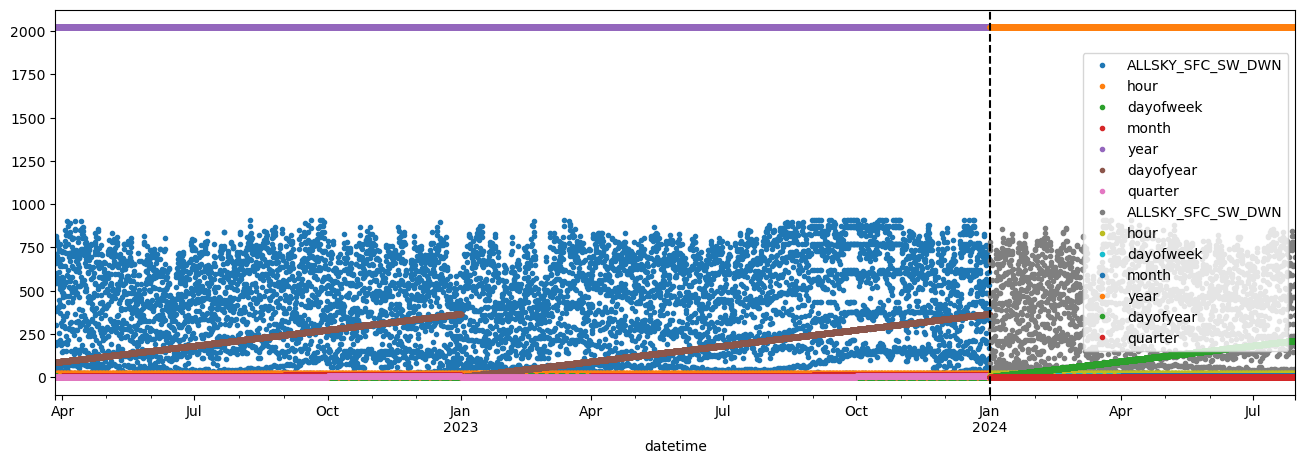

In [39]:
train = new_df.loc[new_df.index < '01-01-2024 00:00:00']
test = new_df.loc[new_df.index >= '01-01-2024 00:00:00']

fig, ax = plt.subplots(figsize=(16,5))
train.plot(ax=ax , label='train',style='.')
test.plot(ax=ax, label='test',style='.')
ax.axvline('01-01-2024',color='black',ls='--')
plt.show()

In [40]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'ALLSKY_SFC_SW_DWN'

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [41]:

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
y_pred = rf_regressor.predict(x_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [56]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 5307.576826585301
R-squared: 0.9260698971067535


In [44]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = tscv)

In [45]:
grid_search.fit(x_train, y_train)
print(grid_search.best_estimator_)


RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=4,
                      min_samples_split=12)


In [46]:
# model_grid = RandomForestClassifier(max_depth=80,
#                                     max_features=3, 
#                                     min_samples_leaf=3,
#                                     min_samples_split=10)
# grid_search.fit(x_train, y_train)
y_pred_grid = grid_search.predict(x_test)

In [58]:
grid_mse = mean_squared_error(y_test, y_pred_grid)
grid_r2 = r2_score(y_test, y_pred_grid)

print('Mean Squared Error:', grid_mse)
print('R-squared:', grid_r2)

Mean Squared Error: 4585.293070121869
R-squared: 0.9361307053019345


In [48]:
test['prediction1'] = y_pred
last_df = new_df.merge(test['prediction1'], how='left', left_index=True, right_index=True)
last_df.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_9820\368783313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction1'] = y_pred


,ALLSKY_SFC_SW_DWN,hour,dayofweek,month,year,dayofyear,quarter,prediction1
datetime,,,,,,,,
2022-03-27 00:00:00,0.0,0,6,3,2022,86,1,NaN
2022-03-27 01:00:00,0.0,1,6,3,2022,86,1,NaN
2022-03-27 02:00:00,0.0,2,6,3,2022,86,1,NaN
2022-03-27 03:00:00,0.0,3,6,3,2022,86,1,NaN
2022-03-27 04:00:00,0.0,4,6,3,2022,86,1,NaN


In [50]:
test['prediction2'] = y_pred_grid
last_df1 = new_df.merge(test['prediction2'], how='left', left_index=True, right_index=True)
last_df1

C:\Users\Acer\AppData\Local\Temp\ipykernel_9820\1942574259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction2'] = y_pred_grid


,ALLSKY_SFC_SW_DWN,hour,dayofweek,month,year,dayofyear,quarter,prediction2
datetime,,,,,,,,
2022-03-27 00:00:00,0.0,0,6,3,2022,86,1,NaN
2022-03-27 01:00:00,0.0,1,6,3,2022,86,1,NaN
2022-03-27 02:00:00,0.0,2,6,3,2022,86,1,NaN
2022-03-27 03:00:00,0.0,3,6,3,2022,86,1,NaN
2022-03-27 04:00:00,0.0,4,6,3,2022,86,1,NaN
...,...,...,...,...,...,...,...,...
2024-07-29 19:00:00,0.0,19,0,7,2024,211,3,1.116276
2024-07-29 20:00:00,0.0,20,0,7,2024,211,3,1.116276
2024-07-29 21:00:00,0.0,21,0,7,2024,211,3,1.116276


In [51]:
last_df1.head()

,ALLSKY_SFC_SW_DWN,hour,dayofweek,month,year,dayofyear,quarter,prediction2
datetime,,,,,,,,
2022-03-27 00:00:00,0.0,0,6,3,2022,86,1,NaN
2022-03-27 01:00:00,0.0,1,6,3,2022,86,1,NaN
2022-03-27 02:00:00,0.0,2,6,3,2022,86,1,NaN
2022-03-27 03:00:00,0.0,3,6,3,2022,86,1,NaN
2022-03-27 04:00:00,0.0,4,6,3,2022,86,1,NaN


In [52]:
last_df.head()

,ALLSKY_SFC_SW_DWN,hour,dayofweek,month,year,dayofyear,quarter,prediction1
datetime,,,,,,,,
2022-03-27 00:00:00,0.0,0,6,3,2022,86,1,NaN
2022-03-27 01:00:00,0.0,1,6,3,2022,86,1,NaN
2022-03-27 02:00:00,0.0,2,6,3,2022,86,1,NaN
2022-03-27 03:00:00,0.0,3,6,3,2022,86,1,NaN
2022-03-27 04:00:00,0.0,4,6,3,2022,86,1,NaN


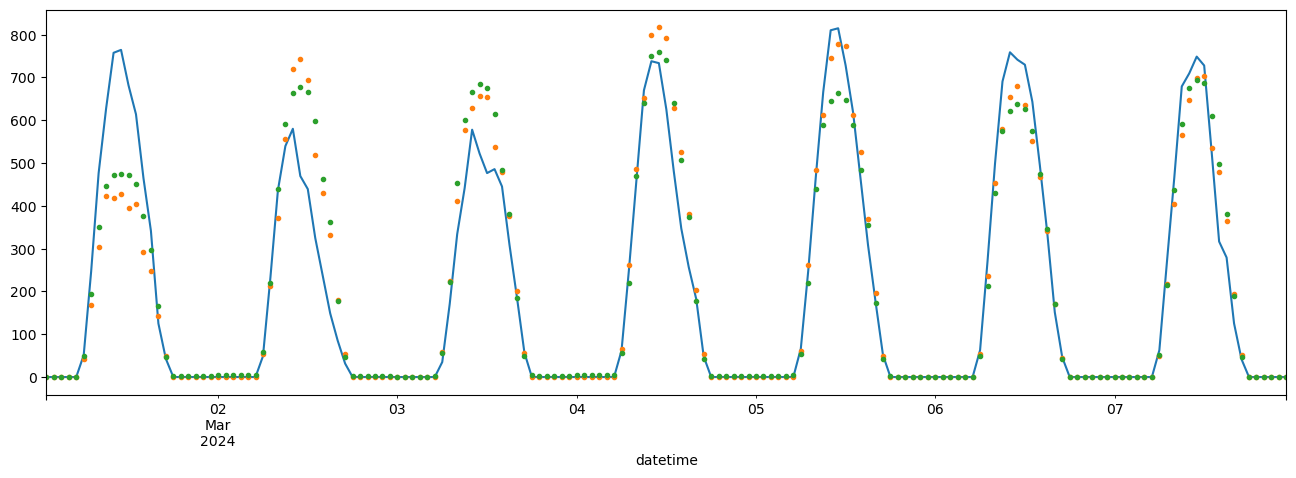

In [53]:
ax = last_df.loc[(last_df.index > '03-01-2024') & (last_df.index < '03-08-2024')]['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,5))
last_df.loc[(last_df.index > '03-01-2024') & (last_df.index < '03-08-2024')]['prediction1'].plot(ax=ax, style='.')
last_df1.loc[(last_df1.index > '03-01-2024') & (last_df1.index < '03-08-2024')]['prediction2'].plot(ax=ax, style='.')
plt.show()

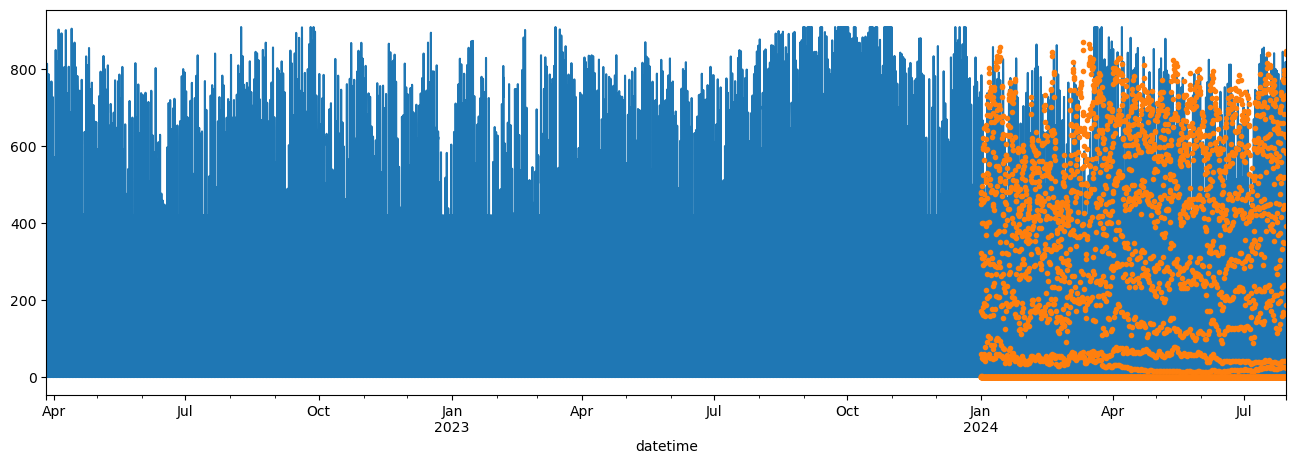

In [54]:
ax = last_df['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,5))
last_df['prediction1'].plot(ax=ax, style='.')
plt.show()

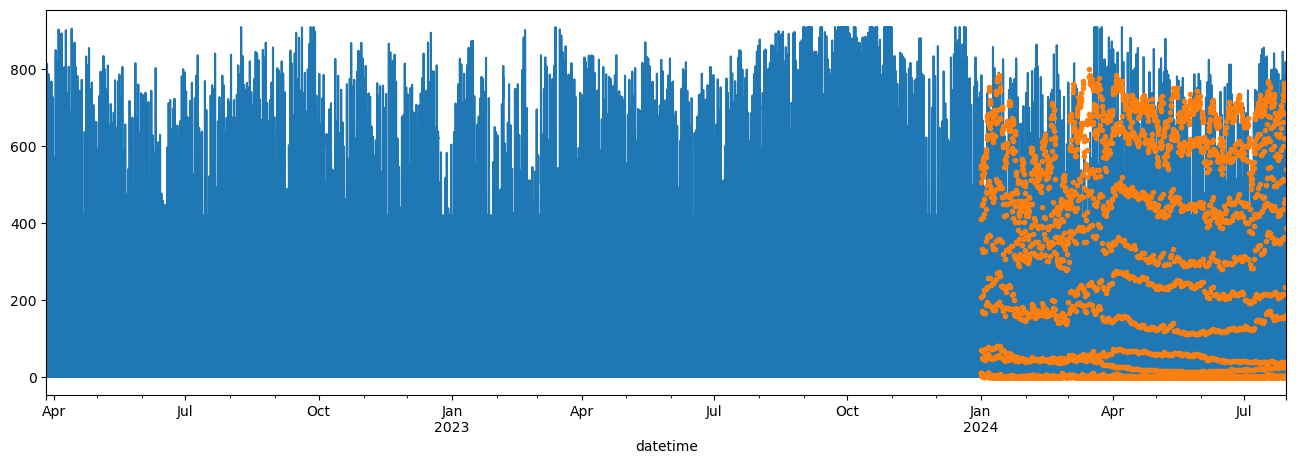

In [55]:
ax = last_df['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,5))
last_df1['prediction2'].plot(ax=ax, style='.')
plt.show()

In [64]:
evaluation = pd.DataFrame ({    
    'model' : ['Randomforest', 'Randomforest gridsearch'],
    'r2_score' : [r2, grid_r2],
    'Mean Squared Error' : [mse, grid_mse],
    })
evaluation

,model,r2_score,Mean Squared Error
0,Randomforest,0.926070,5307.576827
1,Randomforest gridsearch,0.936131,4585.293070


In [65]:
evaluation.to_csv('Evaluation_Model_Score', encoding='utf-8', index=False)